# Tutorial on using MAPLE Package
This will serve as a tutorial to demonstrate the functionality of the MAPLE package. This will serve to demonstrate the capabilities of MAPLE. This tutorial will cover the following-
* Import and set up of test data to generate a dataset object.
* Creating an instance of a model object and passing the dataset object to it.
    * Running inference with the specific model.
    * Adding predicted free energy estimates to it.
* Estimating cumulative performance statistics to compare the different models.
* Visualizing model performance as bar plots and correlation plots.
* Visualize the graph structure .i.e. the graph network
    * Visualize the inference effects (how did do the estimates compare to the original values)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('./'))))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats

# MAPLE imports
from maple.dataset import FEPBenchmarkDataset, FEPDataset
# Model Config Imports
from maple.models import (
     GMVI_model, GMVIConfig, NodeModel, NodeModelConfig, 
    GuideType, PriorType, ErrorDistributionType
)
# Import Performance Plotting functionality
from maple.graph_analysis import (
    plot_dataset_DDGs, plot_dataset_DGs,
    plot_model_comparison_bars, plot_model_comparison_correlation, plot_error_distribution
)
# Import Graph analysis Utility
from maple.graph_analysis import (
    GraphSetup, GraphCycleAnalysis
)

print("✅ All imports successful!")

/opt/homebrew/Caskroom/miniforge/base/envs/maple/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful!


## Start with Loading Data
We can utilize the FEP Benchmark Object to load data from the Schindler FEP Benchmark Repo directly. Its important to note the structure of the dataset object.

In [3]:
# Dataset name and Sampling Time
dataset_name = "cdk8"
sampling_time = "5ns"
# Initialize the FEPBenchmark Data Handler
benchmark = FEPBenchmarkDataset(cache_dir="~/.maple_cache")
#  Load Edge and Node Data
edge_df, node_df = benchmark.get_dataset(dataset_name, sampling_time)

# Lets create the FEP Dataset Object to store the data
dataset = FEPDataset(dataset_edges = edge_df, dataset_nodes=node_df)

📊 Loaded data from provided DataFrames



Error Distribution Analysis: DeltaDeltaG
Number of points: 54
Error range: [-3.7600, 3.2500] kcal/mol

Fitted Normal Distribution:
  Mean (μ): -0.1867 kcal/mol
  Std (σ): 1.5431 kcal/mol
  Variance (σ²): 2.3810 kcal²/mol²

Summary Statistics
Mean error: -0.1867 kcal/mol
Std error: 1.5431 kcal/mol
Median error: -0.4100 kcal/mol
MAE: 1.2211 kcal/mol
RMSE: 1.5543 kcal/mol



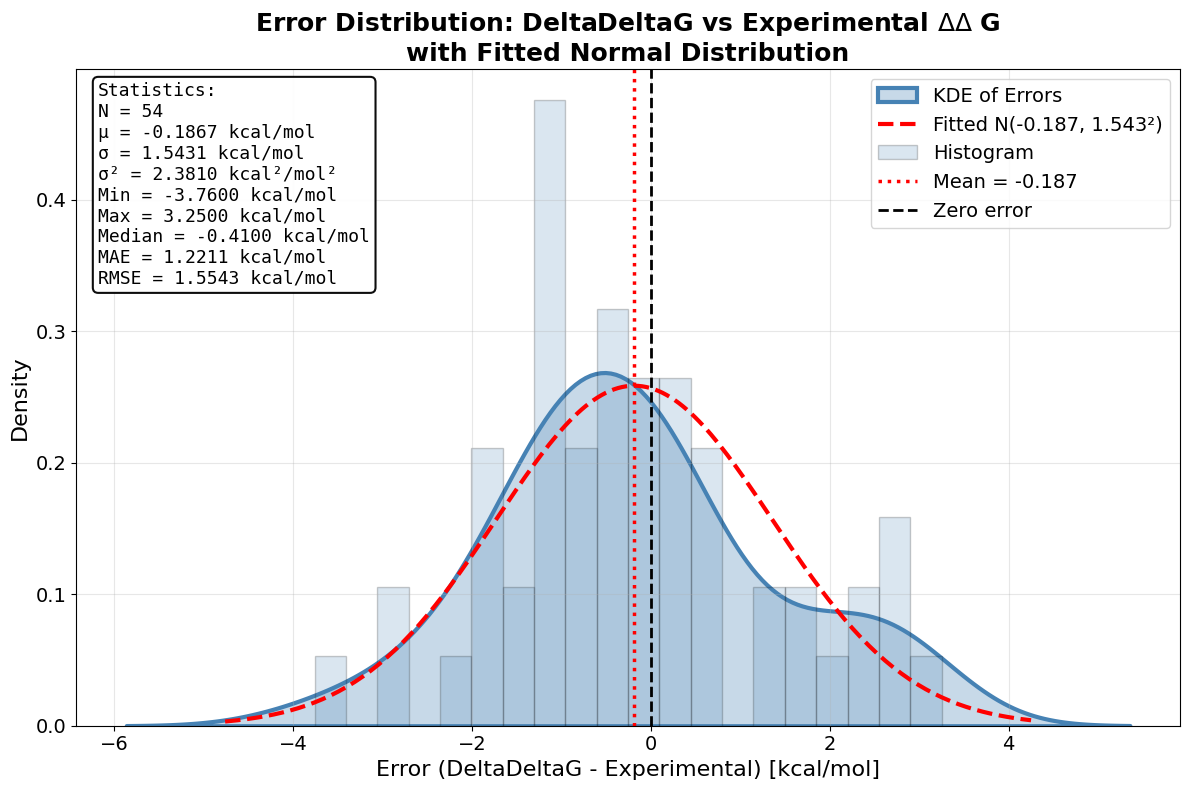

In [4]:
# Generate Error Plot
fig, error_stats = plot_error_distribution(dataset=dataset, predicted_column="DeltaDeltaG", 
experimental_column="Experimental DeltaDeltaG")

## Run Models
In this section we will create Model objects and run inference to estimate the node values.

### Maximum Likelihood Estimate
Bayesian inference with a uniform prior (uninformed prior)

In [5]:
# Create MLE configuration using AutoDelta guide
mle_config = NodeModelConfig(
        prior_type=PriorType.UNIFORM,
        prior_parameters=[-10, 10],
        guide_type=GuideType.AUTO_DELTA,
        num_steps=5000,
        learning_rate=0.001,
        error_std=1.0
    )
# Initialize MLE model
mle_model = NodeModel(config=mle_config, dataset=dataset)

In [6]:
# Train the Model and ensure that the dataset contains the MLE estimates
print("⚙️  Training MLE Model")
print("=" * 50)

# Train MLE Model
print("Starting MLE training...")
mle_model.train()

# Add Predictions to dataset
# Will add an additional column to the edge and the node datasets called MLE
mle_model.add_predictions_to_dataset()

# Check if the MLE predictions were added
if 'MLE' in dataset.dataset_edges.columns:
    print("\n📊 MLE predictions added to dataset:")
    display(dataset.dataset_edges[['Source', 'Destination', 'DeltaDeltaG', 'MLE']].head())

⚙️  Training MLE Model
Starting MLE training...
Step 0: Loss = 730.6947
Step 1000: Loss = 214.9405
Step 2000: Loss = 164.9870
Step 3000: Loss = 156.2140
Step 4000: Loss = 153.6966

📊 MLE predictions added to dataset:


,Source,Destination,DeltaDeltaG,MLE
0,30,25,-0.49,-1.024459
1,30,29,1.00,1.056999
2,30,32,-0.27,0.250808
3,4,3,-1.04,-1.101483
4,4,12,-4.56,-3.919959


### Maximum A Posteriori Estimate
This just uses a standard Gaussian Prior.

In [7]:
# Create MAP configuration using AutoDelta guide
map_config = NodeModelConfig(
    learning_rate=0.001,
    num_steps=5000,
    error_std=1.0,
    guide_type=GuideType.AUTO_DELTA,  # Use AutoDelta for MAP with no uncertainty estimates
    prior_type=PriorType.NORMAL,
    prior_std=1.0
)

# Initialize MAP Model
map_model = NodeModel(config=map_config, dataset=dataset)

In [8]:
# Train the Model and ensure that the dataset contains the MAP estimates
print("⚙️  Training MAP Model")
print("=" * 50)

# Train the VI model
print("Starting MAP training...")
map_model.train()

# Add predictions to dataset
map_model.add_predictions_to_dataset()

# Check that VI predictions were added
if 'MAP' in dataset.dataset_edges.columns:
    print("\n📊 MAP predictions added to dataset:")
    display(dataset.dataset_edges[['Source', 'Destination', 'DeltaDeltaG', 'MAP']].head())

⚙️  Training MAP Model
Starting MAP training...
Step 0: Loss = 174.0898
Step 1000: Loss = 130.0678
Step 2000: Loss = 121.0725
Step 3000: Loss = 118.2496
Step 4000: Loss = 117.0902

📊 MAP predictions added to dataset:


,Source,Destination,DeltaDeltaG,MAP
0,30,25,-0.49,-0.411455
1,30,29,1.00,0.343890
2,30,32,-0.27,-0.390785
3,4,3,-1.04,-0.798019
4,4,12,-4.56,-2.082623


### Full Variational Inference
This performs full Bayesian inference and returns uncertainties associated with inferred parameters. MAP is a point estimate for each parameter while VI generates a distribution and hence an uncertainty values for each of the parameters.

In [9]:
# Create VI configuration using AutoNormal guide for uncertainty quantification
vi_config = NodeModelConfig(
    learning_rate=0.001,
    num_steps=5000,
    error_std=1.0,
    guide_type=GuideType.AUTO_NORMAL,  # Use AutoNormal for VI with uncertainty
    prior_type="normal",
    prior_std=1.0
)

# Initialize VI model
vi_model = NodeModel(config=vi_config, dataset=dataset)

In [10]:
# Train the Model and ensure that the dataset contains the MAP estimates
print("⚙️ Training VI Model")
print("=" * 50)

# Train the VI model
print("Starting VI training...")
vi_model.train()

# Add predictions to dataset
vi_model.add_predictions_to_dataset()

# Check that VI predictions were added
if 'VI' in dataset.dataset_edges.columns:
    print("\n📊 VI predictions added to dataset:")
    display(dataset.dataset_edges[['Source', 'Destination', 'DeltaDeltaG', 'VI']].head())

⚙️ Training VI Model
Starting VI training...
Step 0: Loss = 211.1049
Step 1000: Loss = 141.1185
Step 2000: Loss = 111.1876
Step 3000: Loss = 115.1180
Step 4000: Loss = 113.8936

📊 VI predictions added to dataset:


,Source,Destination,DeltaDeltaG,VI
0,30,25,-0.49,-0.400291
1,30,29,1.00,0.261930
2,30,32,-0.27,-0.372889
3,4,3,-1.04,-0.959159
4,4,12,-4.56,-2.165037


### GMVI Model
This model set up is different from the others and uses a different configuration.

In [11]:
# Create GMVI configuration
gmvi_config = GMVIConfig(
    prior_std=1.0,          # Prior standard deviation for node values
    normal_std=1.0,         # Standard deviation for normal edges
    outlier_std=5.0,        # Standard deviation for outlier edges
    outlier_prob=0.2,       # Probability of an edge being an outlier
    kl_weight=0.1,          # Weight for KL divergence in ELBO
    learning_rate=0.001,     # Learning rate for ADAM optimizer
    n_epochs=5000,           # Number of training epochs
    n_samples=700,          # Monte Carlo samples for ELBO
    patience=300             # Early stopping patience
)

# Initialize the model with config
gmvi_model = GMVI_model(dataset=dataset, config=gmvi_config)

Parameters initialized
✅ Parameters initialized

Starting optimization...
Starting optimization...
Parameters initialized
Epoch 0: ELBO = -133.5224, Loss = 133.5224
Epoch 100: ELBO = -124.7352, Loss = 124.7352
Epoch 200: ELBO = -119.3411, Loss = 119.3411
Epoch 300: ELBO = -115.2755, Loss = 115.2755
Epoch 400: ELBO = -110.8770, Loss = 110.8770
Epoch 500: ELBO = -106.5308, Loss = 106.5308
Epoch 600: ELBO = -103.6610, Loss = 103.6610
Epoch 700: ELBO = -99.8030, Loss = 99.8030
Epoch 800: ELBO = -96.5463, Loss = 96.5463
Epoch 900: ELBO = -93.3438, Loss = 93.3438
Epoch 1000: ELBO = -90.6359, Loss = 90.6359
Epoch 1100: ELBO = -88.6030, Loss = 88.6030
Epoch 1200: ELBO = -86.5632, Loss = 86.5632
Epoch 1300: ELBO = -84.8786, Loss = 84.8786
Epoch 1400: ELBO = -83.3620, Loss = 83.3620
Epoch 1500: ELBO = -82.0870, Loss = 82.0870
Epoch 1600: ELBO = -80.9845, Loss = 80.9845
Epoch 1700: ELBO = -80.1562, Loss = 80.1562
Epoch 1800: ELBO = -79.1926, Loss = 79.1926
Epoch 1900: ELBO = -78.5056, Loss = 78.5

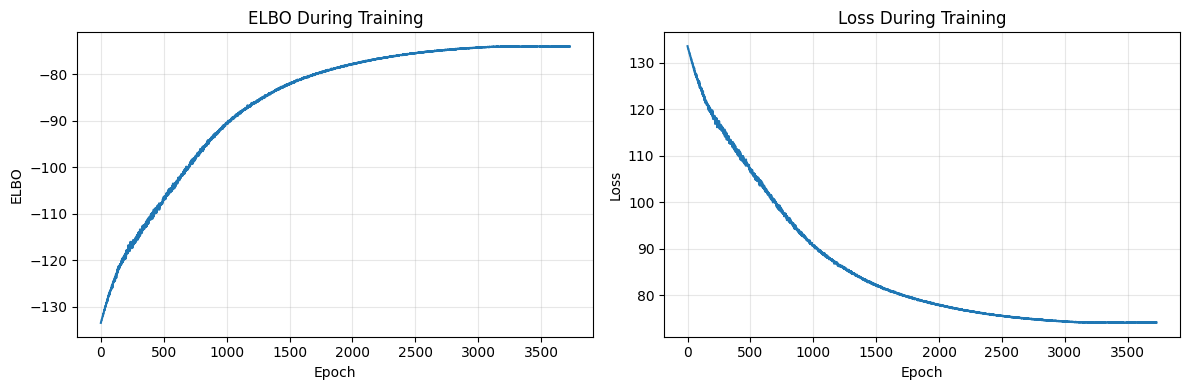

In [12]:
# Initialize parameters
gmvi_model.initialize_parameters()
print("✅ Parameters initialized")

# Fit the model
print("\nStarting optimization...")
gmvi_model.fit()

# Plot training history
if gmvi_model.elbo_history:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gmvi_model.elbo_history)
    plt.xlabel('Epoch')
    plt.ylabel('ELBO')
    plt.title('ELBO During Training')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(gmvi_model.loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [13]:
# Extract the Posterior Estimates and add GMVI estimates to the dataset
estimates = gmvi_model.get_posterior_estimates()

print(f"\nNode estimates:")
print(f"  Number of nodes: {len(estimates['means'])}")
print(f"  Mean value range: [{estimates['means'].min():.3f}, {estimates['means'].max():.3f}]")
print(f"  Mean uncertainty: {estimates['stds'].mean():.3f}")

# Add predictions to dataset
gmvi_model.add_predictions_to_dataset()

# Check that predictions were added
print("\nNode predictions added:")
if 'GMVI' in dataset.dataset_nodes.columns:
    print("✅ GMVI column added to nodes")
    display(dataset.dataset_nodes[['Name', 'Exp. DeltaG', 'GMVI', 'GMVI_uncertainty']].head())

print("\nEdge predictions added:")
if 'GMVI' in dataset.dataset_edges.columns:
    print("✅ GMVI column added to edges")
    display(dataset.dataset_edges[['Source', 'Destination', 'DeltaDeltaG', 'GMVI', 'GMVI_uncertainty']].head())


Node estimates:
  Number of nodes: 33
  Mean value range: [-2.525, 2.599]
  Mean uncertainty: 0.279

Node predictions added:
✅ GMVI column added to nodes


,Name,Exp. DeltaG,GMVI,GMVI_uncertainty
0,0,-11.22,-0.732246,0.281211
1,1,-8.29,2.200106,0.277921
2,2,-7.64,2.599186,0.318091
3,3,-9.24,1.380619,0.241882
4,5,-10.91,1.186812,0.256369



Edge predictions added:
✅ GMVI column added to edges


,Source,Destination,DeltaDeltaG,GMVI,GMVI_uncertainty
0,30,25,-0.49,-0.790218,0.419292
1,30,29,1.00,0.862115,0.392137
2,30,32,-0.27,0.036959,0.401103
3,4,3,-1.04,-1.193143,0.366044
4,4,12,-4.56,-3.394392,0.384171


## Generate Performance Plots
In this section we will generate performance plots that compare the performance of different models in correcting Free energy estimates.

Using predicted column: MAP


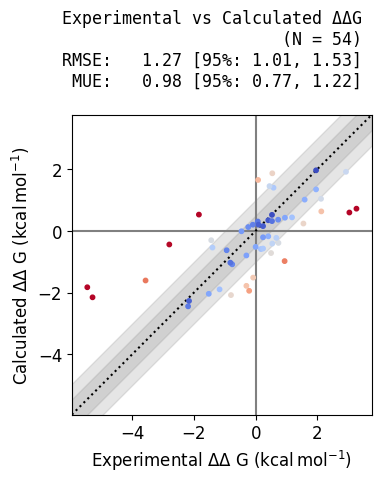

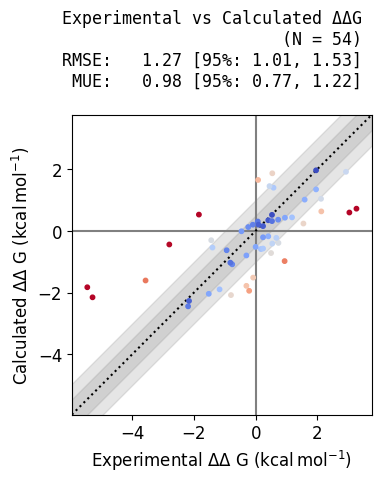

In [14]:
# If I want to look at individual methods
plot_dataset_DDGs(dataset=dataset, predicted_column="MAP") 

Using predicted column: MAP


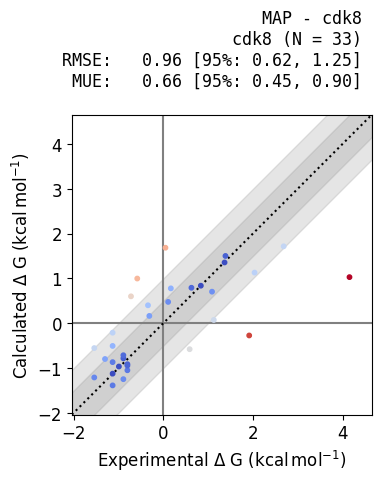

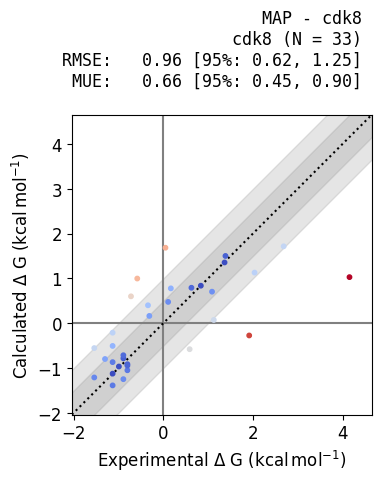

In [15]:
# Same thing but if we want to look at the node estimates
plot_dataset_DGs(dataset=dataset, predicted_column="MAP", method_name="MAP", target_name="cdk8", )

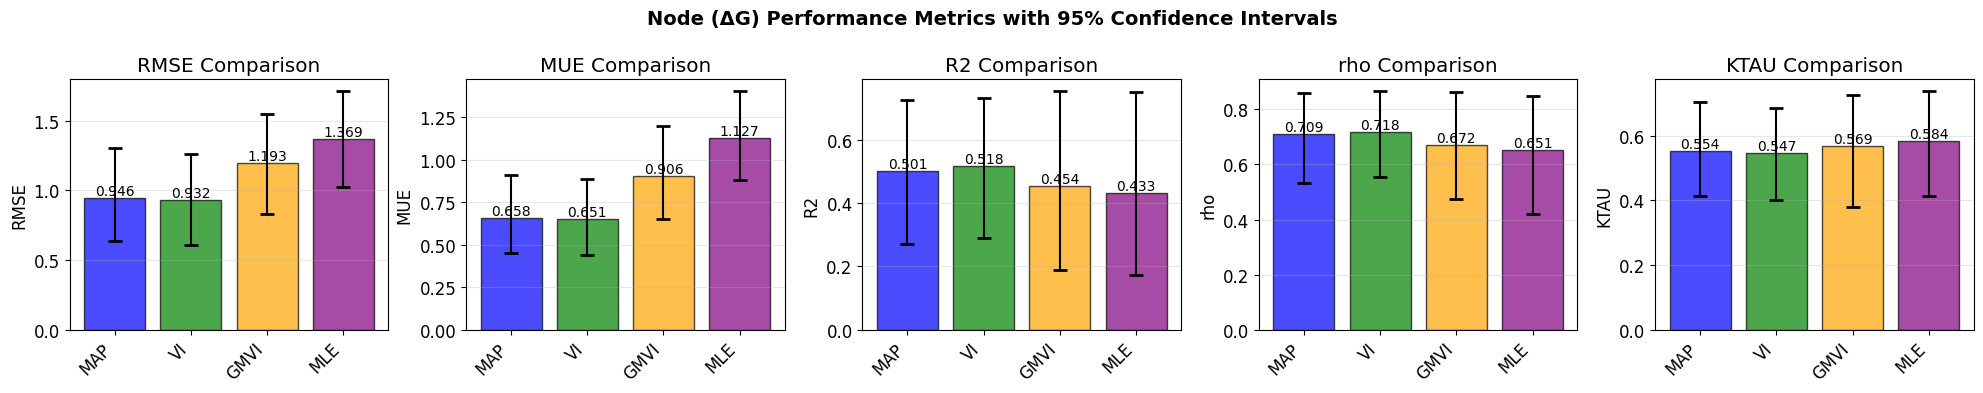

In [16]:
# Barplots for comparing Node estimates
figure, _ = plot_model_comparison_bars(dataset=dataset)

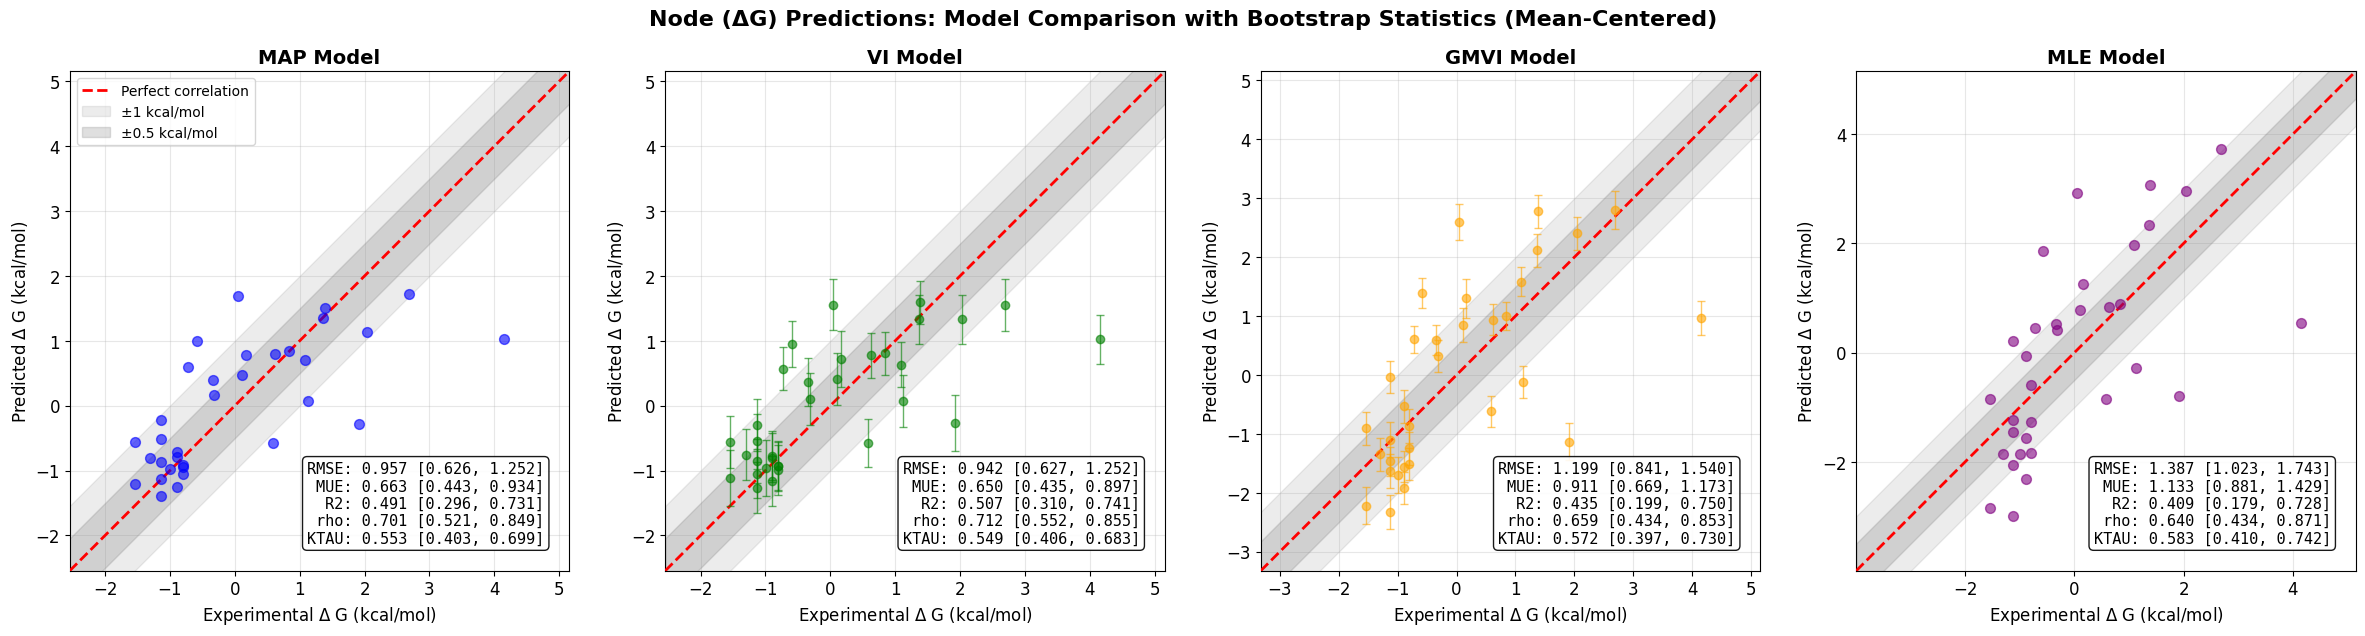

In [17]:
# Correlation Plots for node estimates
figure, stats_df = plot_model_comparison_correlation(dataset=dataset)

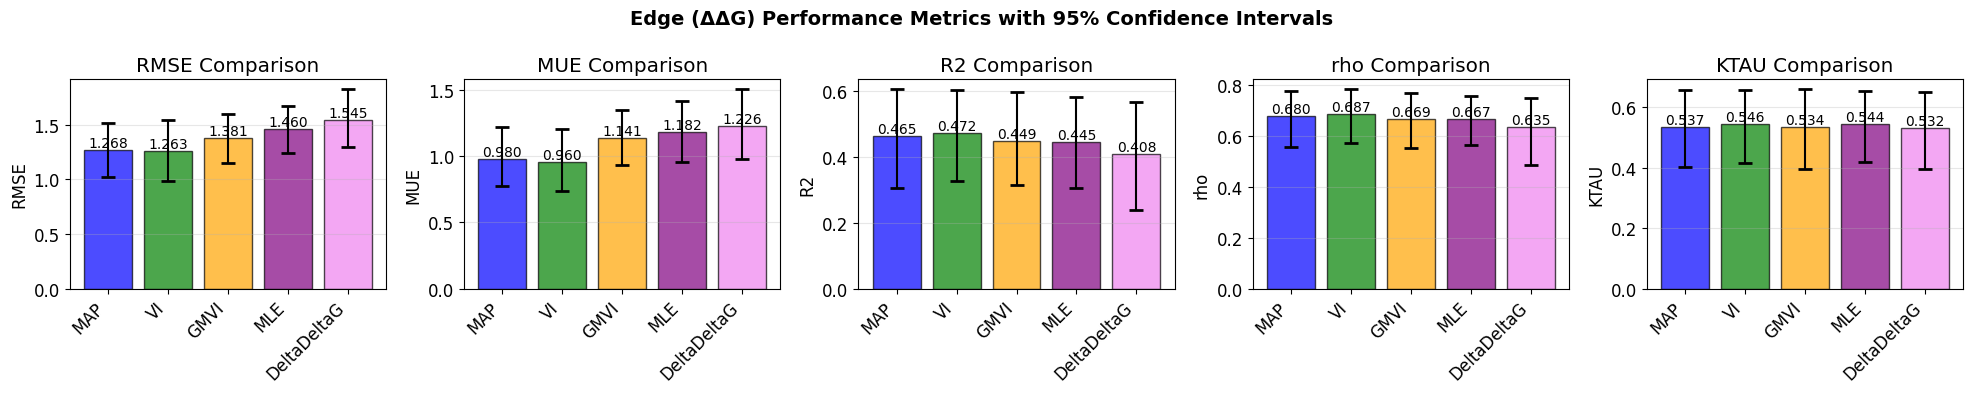

In [18]:
# Barplots for edge predictions
figure, _ = plot_model_comparison_bars(dataset=dataset, data_type="edges", return_stats=False)

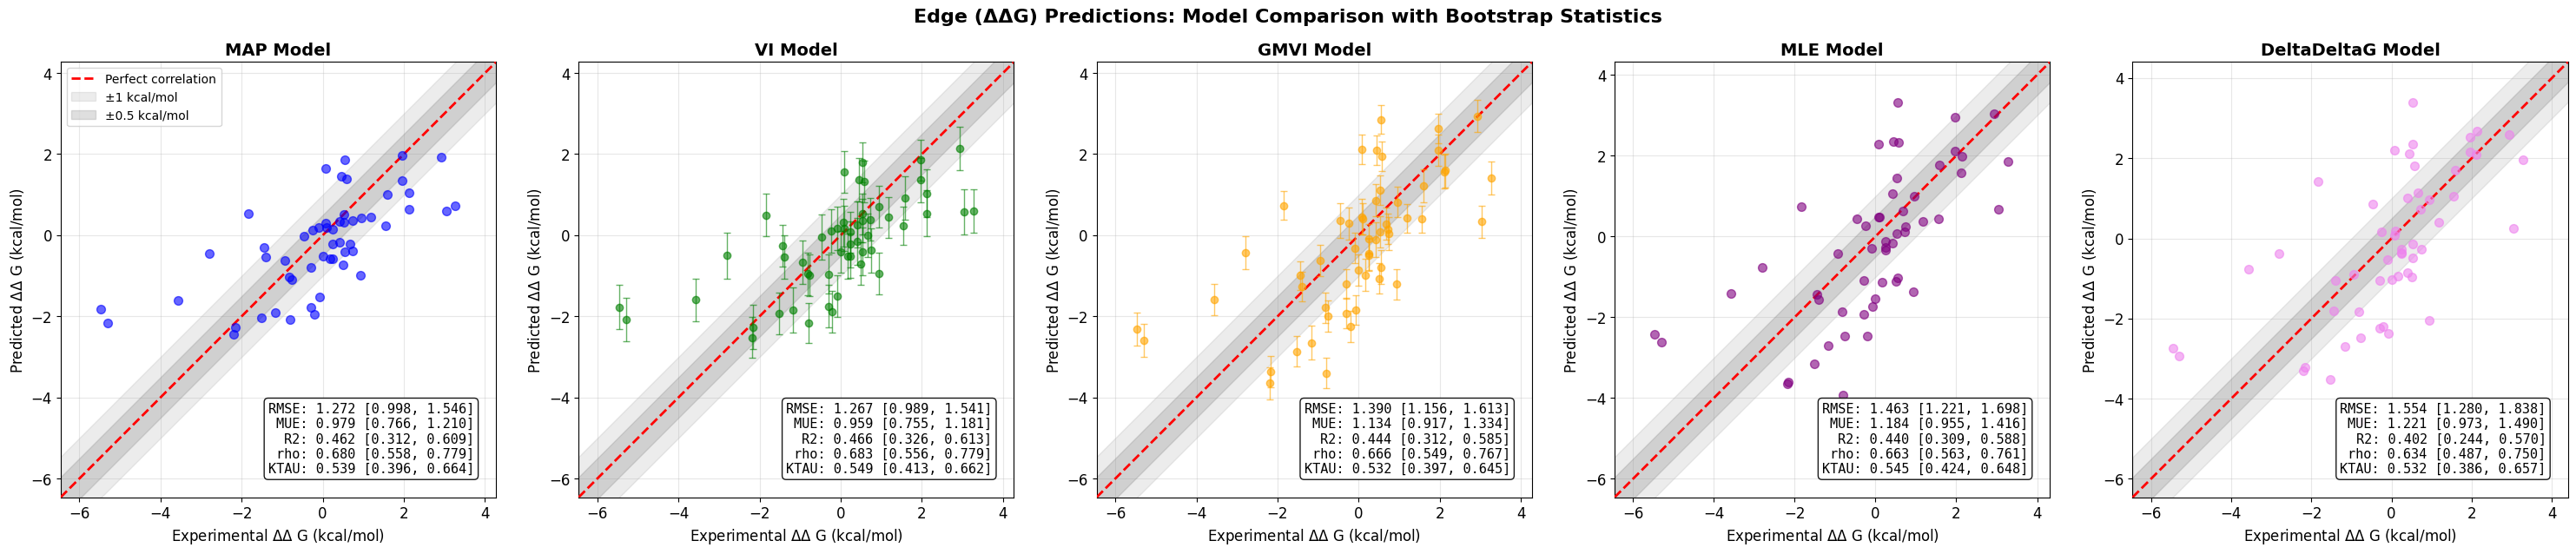

In [19]:
figure, _ = plot_model_comparison_correlation(dataset=dataset, data_type="edges")

## Graph Visualization and Analysis
Here we can visualize the overall topology of the graph.
We also look at how the predictions have changed the FEP values from the original input.

In [20]:
graph_analysis = GraphSetup(dataset)
graph_analysis_cycle = GraphCycleAnalysis(graph_analysis)

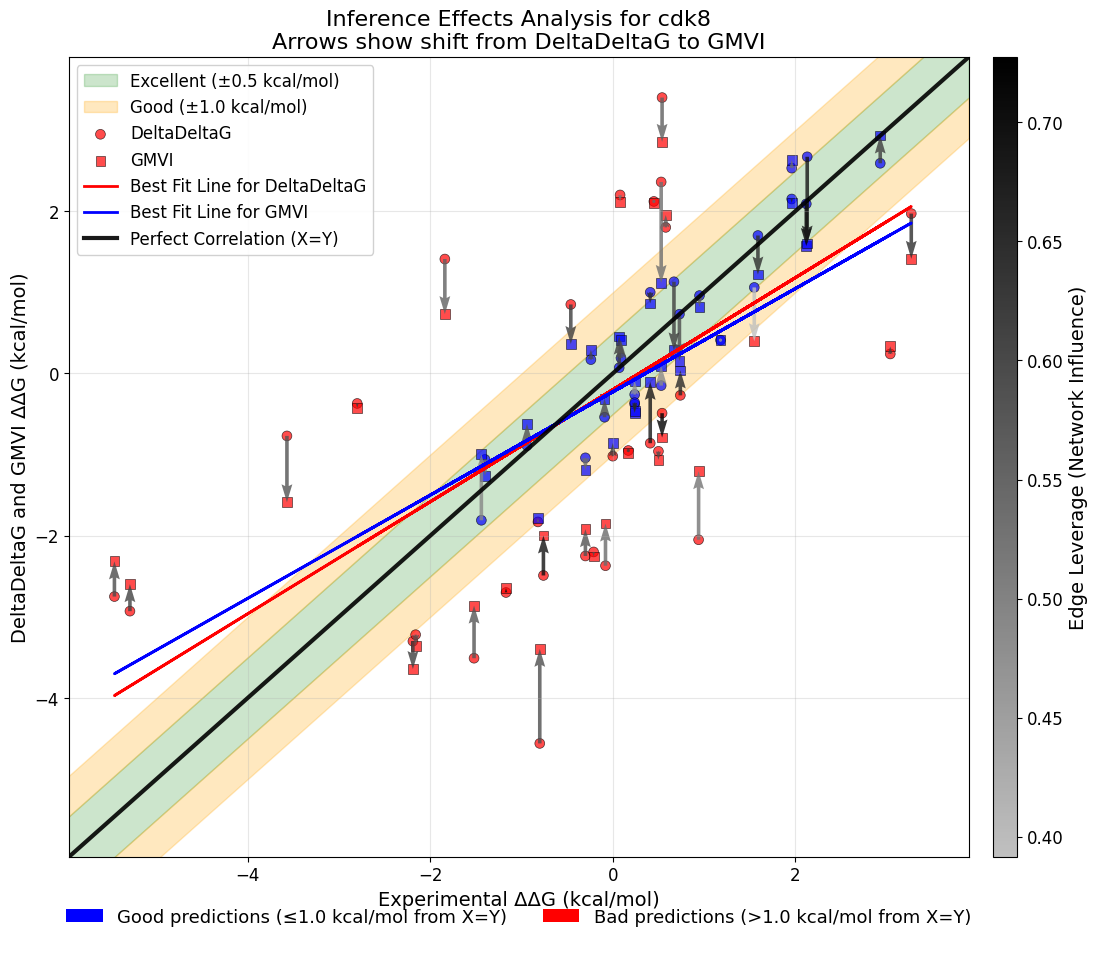

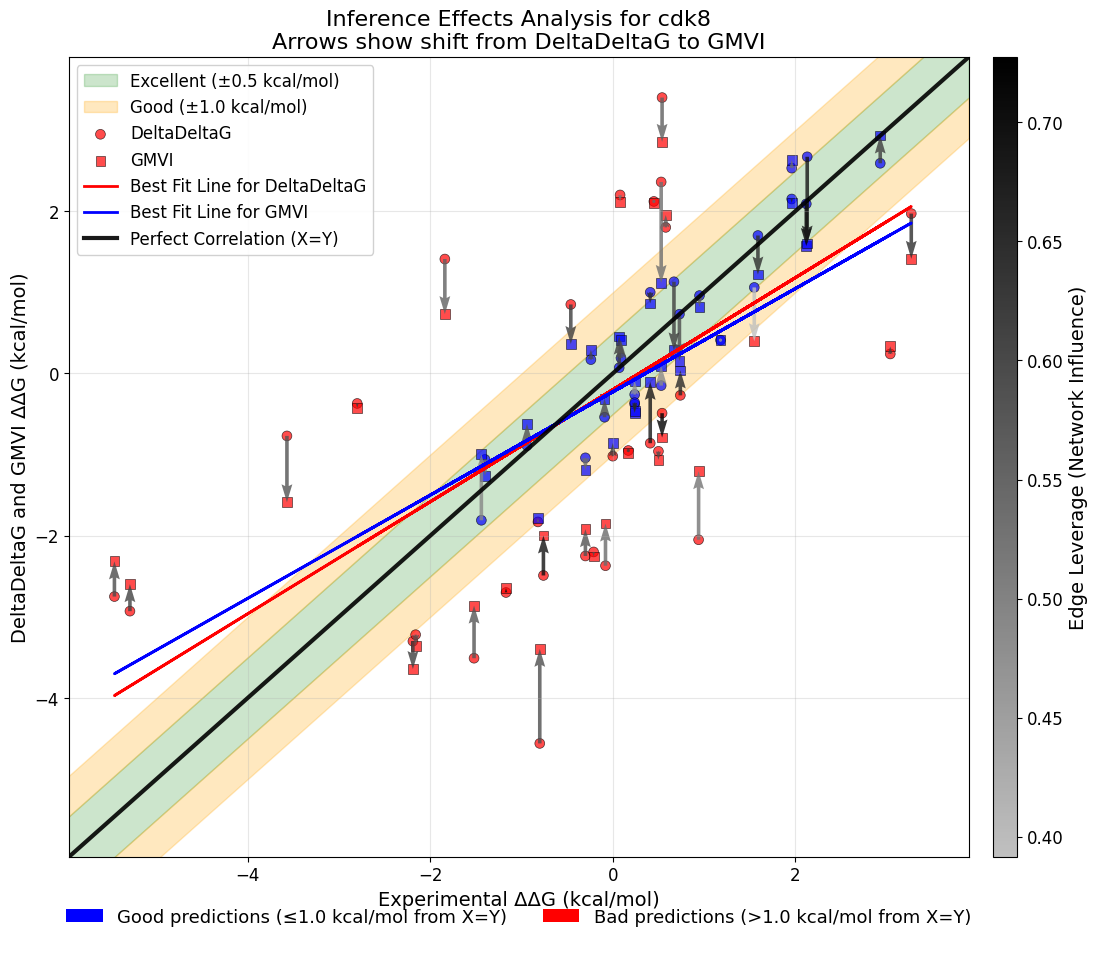

In [21]:
graph_analysis_cycle.visualize_inference_effects(target_name="cdk8", comparison_attribute="GMVI")

In [23]:
node_df

,Name,Pred. DeltaG,Pred. Error,Exp. DeltaG,Dataset,Sampling Time,Exp. Error
0,0,-10.32,0.18,-11.22,cdk8,5ns,0.0
1,1,-7.31,0.19,-8.29,cdk8,5ns,0.0
2,2,-6.53,0.18,-7.64,cdk8,5ns,0.0
3,3,-8.29,0.18,-9.24,cdk8,5ns,0.0
4,5,-8.43,0.17,-10.91,cdk8,5ns,0.0
5,4,-7.09,0.18,-8.94,cdk8,5ns,0.0
6,6,-9.75,0.21,-10.67,cdk8,5ns,0.0
7,7,-9.95,0.18,-10.64,cdk8,5ns,0.0
8,8,-9.46,0.21,-9.70,cdk8,5ns,0.0
9,9,-9.53,0.25,-10.22,cdk8,5ns,0.0
